In [147]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Reading the Datasets**

In [148]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.drop(columns = ['rainfall'], axis = 1)
train_len = len(train)
test_len = len(test)
merged_df = pd.concat([train,test], axis = 0, ignore_index = True)

**PreProcessing**

In [149]:
merged_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8


In [150]:
merged_df.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [151]:
merged_df.fillna(test.mean(), inplace=True)

**EDA**

<Axes: >

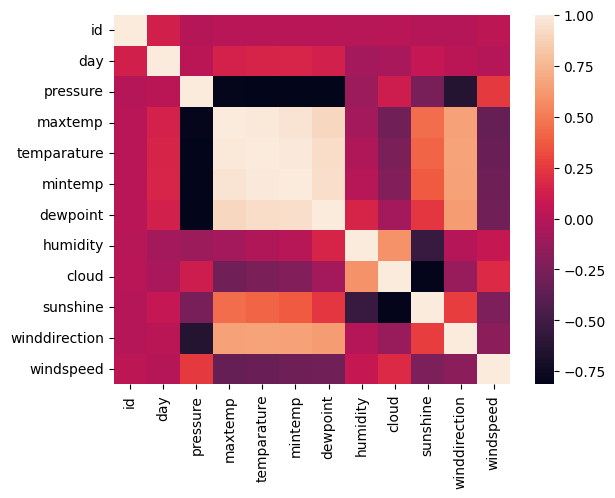

In [152]:
corr = merged_df.corr()
sns.heatmap(corr)

**Feature Engineering**

In [153]:
#humidity and dewpoint interaction 
merged_df['humidity_dewpoint_diff'] = merged_df['humidity'] - merged_df['dewpoint']
merged_df['humidity_dewpoint_ratio'] = merged_df['humidity'] / (merged_df['dewpoint'] + 1e-5)

In [154]:
#pressure and windspeed interamerged_df
merged_df['storm_potential'] = merged_df['pressure'] * merged_df['windspeed']

In [155]:
#temprange
merged_df['temp_range'] = merged_df['maxtemp'] - merged_df['mintemp']

In [156]:
#wind interaction
merged_df['wind_interaction'] = merged_df['windspeed'] * merged_df['winddirection']

In [157]:
#rolling mean and median 
merged_df['rolling_mean_temperature'] = merged_df['temparature'].rolling(window=7).mean()

In [158]:
merged_df.skew()

id                           0.000000
day                          0.022982
pressure                     0.299044
maxtemp                     -0.503202
temparature                 -0.570190
mintemp                     -0.653710
dewpoint                    -1.018383
humidity                    -0.564495
cloud                       -1.334801
sunshine                     0.649794
winddirection                0.714163
windspeed                    0.766272
humidity_dewpoint_diff       0.291405
humidity_dewpoint_ratio     54.037024
storm_potential              0.769274
temp_range                   0.302918
wind_interaction             1.694657
rolling_mean_temperature    -0.460824
dtype: float64

In [159]:
import pandas as pd
import numpy as np
from scipy.stats import skew

# Assuming 'merged_df' is your DataFrame

# Select only numeric columns to calculate skewness and apply log transformation
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns

# Print the skewness before transformation
print("Original skewness:", merged_df[numeric_columns].skew())

# Perform log(1 + x) transformation on columns with skewness > 1
for column in numeric_columns:
    if skew(merged_df[column]) > 1:
        # Apply log(1 + x) to avoid issues with zero or negative values
        # Ensure that we have no zeros or negative values
        if (merged_df[column] > -1).all():  # Only apply log(1 + x) if all values are greater than -1
            merged_df[column] = np.log1p(merged_df[column])  # log(1 + x)

# Check for NaN or infinite values in the dataset after the transformation
print("Number of NaN values per column after transformation:", merged_df.isna().sum())
print("Number of Inf values per column after transformation:", np.isinf(merged_df).sum())

# Replace Inf values with NaN
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, replace NaN values with the mean of each column
merged_df.fillna(merged_df.mean(), inplace=True)

# Check skewness after applying transformation
print("Skewness after transformation:", merged_df[numeric_columns].skew())


Original skewness: id                           0.000000
day                          0.022982
pressure                     0.299044
maxtemp                     -0.503202
temparature                 -0.570190
mintemp                     -0.653710
dewpoint                    -1.018383
humidity                    -0.564495
cloud                       -1.334801
sunshine                     0.649794
winddirection                0.714163
windspeed                    0.766272
humidity_dewpoint_diff       0.291405
humidity_dewpoint_ratio     54.037024
storm_potential              0.769274
temp_range                   0.302918
wind_interaction             1.694657
rolling_mean_temperature    -0.460824
dtype: float64
Number of NaN values per column after transformation: id                          0
day                         0
pressure                    0
maxtemp                     0
temparature                 0
mintemp                     0
dewpoint                    0
humidity          

In [160]:
columns_to_transform = ['humidity_dewpoint_ratio']  

for column in columns_to_transform:
    merged_df[column] = np.log1p(merged_df[column])

/home/yusuf/Workspace/ML Projects/Rainfall_Prediction_Kaggle/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [161]:
merged_df.skew()

id                           0.000000
day                          0.022982
pressure                     0.299044
maxtemp                     -0.503202
temparature                 -0.570190
mintemp                     -0.653710
dewpoint                    -1.018383
humidity                    -0.564495
cloud                       -1.334801
sunshine                     0.649794
winddirection                0.714163
windspeed                    0.766272
humidity_dewpoint_diff       0.291405
humidity_dewpoint_ratio     16.154850
storm_potential              0.769274
temp_range                   0.302918
wind_interaction            -0.304912
rolling_mean_temperature    -0.461298
dtype: float64

**Model Training**

In [162]:
train = merged_df[:train_len]
test = merged_df[train_len:]
train_df = pd.read_csv('train.csv')
train['rainfall'] = train_df['rainfall']

/tmp/ipykernel_4234/1477254156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['rainfall'] = train_df['rainfall']


In [171]:
train.isnull().sum()

id                          0
day                         0
pressure                    0
maxtemp                     0
temparature                 0
mintemp                     0
dewpoint                    0
humidity                    0
cloud                       0
sunshine                    0
winddirection               0
windspeed                   0
humidity_dewpoint_diff      0
humidity_dewpoint_ratio     0
storm_potential             0
temp_range                  0
wind_interaction            0
rolling_mean_temperature    0
rainfall                    0
dtype: int64

In [170]:
train.fillna(test.mean(), inplace=True)

/tmp/ipykernel_4234/1550602387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.fillna(test.mean(), inplace=True)


In [172]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = train.drop(columns = ['rainfall'], axis = 1)
y = train['rainfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [164]:
'''from sklearn.linear_model import LinearRegression

model1 = LinearRegression()

model1.fit(X_train, y_train)

pred = model1.predict(X_test)'''

'from sklearn.linear_model import LinearRegression\n\nmodel1 = LinearRegression()\n\nmodel1.fit(X_train, y_train)\n\npred = model1.predict(X_test)'

In [165]:
'''from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression()

model2.fit(X_train, y_train)'''

'from sklearn.linear_model import LogisticRegression\n\nmodel2 = LogisticRegression()\n\nmodel2.fit(X_train, y_train)'

In [166]:
'''from sklearn.ensemble import RandomForestRegressor

model3 = RandomForestRegressor()

model3.fit(X_train, y_train)'''

'from sklearn.ensemble import RandomForestRegressor\n\nmodel3 = RandomForestRegressor()\n\nmodel3.fit(X_train, y_train)'

In [167]:
'''from lightgbm import LGBMRegressor

model4 = LGBMRegressor()

model4.fit(X_train, y_train)'''

'from lightgbm import LGBMRegressor\n\nmodel4 = LGBMRegressor()\n\nmodel4.fit(X_train, y_train)'

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor


base_learners = [
    ('lr', LinearRegression()),  
    ('lgbm', LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42))  
]

final_estimator = LinearRegression()

stacking_regressor = StackingRegressor(estimators=base_learners, final_estimator=final_estimator)

stacking_regressor.fit(X_train, y_train)

y_pred = stacking_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'rmse: {np.sqrt(mse)}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3229
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 18
[LightGBM] [Info] Start training from score 0.759703
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3146
[LightGBM] [Info] Number of data points in the train set: 1401, number of used features: 18
[LightGBM] [Info] Start training from score 0.752320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3132
[LightGBM] [Info] Number of data points in the train set: 1401, number of used features: 18
[LightGBM] [Info] Start traini

In [174]:
predictions = stacking_regressor.predict(test)

submission = pd.DataFrame({
    'id': test['id'],
    'rainfall': predictions
})

submission.to_csv('submission_3.csv', index = False)